# Deliverable 2

- Deliverable 2 will be a NER (Named entity recognition system).


In [4]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from Spelling_Correction_c  import Spelling_Correction_c 

## Load and clean data set

We start by loading the original data and cleaning it. That is, in the column `Sentence #`, we replace all the NAN values by the actual sentence number. Then, we save this data set to use it in the reproduce\_results.ipynb notebook. 

In [5]:
data = pd.read_csv("../data/ner_dataset.csv", encoding="latin1")

last_n = 35970

sentence_formatter = "Sentence: {}"
end   = data.index[data["Sentence #"] == sentence_formatter.format(last_n)][0]

In [6]:
data_train = data[0:end]

data_test = data[end:]

In [8]:
n_sentences = len(list(set(data_train["Sentence #"])))
first_n = 1
last_n = last_n -1
print(n_sentences)

35970


In [ ]:
%%time 

for s_id in range(first_n, last_n):
    print("current {}/{}".format(s_id,last_n), end="\r")
    sentence_id = sentence_formatter.format(s_id)
    sentence_id_next = sentence_formatter.format(s_id + 1)
    start = data_train.index[data_train["Sentence #"] == sentence_id][0]
    end   = data_train.index[data_train["Sentence #"] == sentence_id_next][0]
    data_train["Sentence #"][start:end] = sentence_id
    
sentence_id = sentence_formatter.format(last_n)
start = data_train.index[data_train["Sentence #"] == sentence_id][0]
end   = data_train.shape[0]
data_train["Sentence #"][start:end] = sentence_id


In [171]:
%%time 

first_n = 35970
last_n = 47959

index0 = data_test.index[0]

for s_id in range(first_n, last_n):
    print("current {}/{}".format(s_id,last_n), end="\r")
    sentence_id = sentence_formatter.format(s_id)
    sentence_id_next = sentence_formatter.format(s_id + 1)
    start = data_test.index[data_test["Sentence #"] == sentence_id][0]- index0
    end   = data_test.index[data_test["Sentence #"] == sentence_id_next][0]- index0
    data_test["Sentence #"][start:end] = sentence_id
    
sentence_id = sentence_formatter.format(last_n)
start = data_test.index[data_test["Sentence #"] == sentence_id][0] - index0
end   = data_test.index[-1] - index0 + 1
data_test["Sentence #"][start:end] = sentence_id

CPU times: user 7min 51s, sys: 1.11 s, total: 7min 52s
Wall time: 7min 50s


### Save cleaned datasets into file

In [175]:
data_train.to_csv("clean_train.csv")

data_test.to_csv("clean_test.csv")

### Load cleaned datasets

In [7]:
data_train = pd.read_csv("clean_train.csv")

data_test = pd.read_csv("clean_test.csv")

data_test

,Unnamed: 0,Sentence #,Word,POS,Tag
0,786856,Sentence: 35970,Haitian,JJ,B-gpe
1,786857,Sentence: 35970,police,NNS,O
2,786858,Sentence: 35970,have,VBP,O
3,786859,Sentence: 35970,killed,VBN,O
4,786860,Sentence: 35970,a,DT,O
...,...,...,...,...,...
261714,1048570,Sentence: 47959,they,PRP,O
261715,1048571,Sentence: 47959,responded,VBD,O
261716,1048572,Sentence: 47959,to,TO,O
261717,1048573,Sentence: 47959,the,DT,O


## Building X and Y from data

Given the clean data set, we generate the clean X and Y variables for both training, validation and test sets.
We also create the dictionaries `word\_to\_pos` and `tag_to_pos` for the HMM and Perceptron models.

### Training data

In [8]:
%%time 
X_train = []
Y_train = []

curr_sent = 'Sentence: 1'
list_sent = []
list_y = []
for i in range(data_train.shape[0]):
    if data_train["Sentence #"][i] == curr_sent:
        list_sent.append(data_train['Word'][i])
        list_y.append(data_train['Tag'][i])
    else:
        curr_sent = data_train["Sentence #"][i]
        X_train.append(list_sent)
        Y_train.append(list_y)
        list_sent = [data_train['Word'][i]]
        list_y = [data_train['Tag'][i]]


Wall time: 28.7 s


### Test data

In [9]:
%%time 
X_test = []
Y_test = []

curr_sent = 'Sentence: 35970'
list_sent = []
list_y = []
for i in range(data_test.shape[0]):
    if data_test["Sentence #"][i] == curr_sent:
        list_sent.append(data_test['Word'][i])
        list_y.append(data_test['Tag'][i])
    else:
        curr_sent = data_test["Sentence #"][i]
        X_test.append(list_sent)
        Y_test.append(list_y)
        list_sent = [data_test['Word'][i]]
        list_y = [data_test['Tag'][i]]


Wall time: 9.34 s


### Build dictionaries

In [10]:
def build_word_to_pos(X):

    word_to_pos = {}
    i = 0
    for s in X:
        for w in s:
            if w not in word_to_pos:
                word_to_pos[w] = i
                i +=1
                
    pos_to_word = {v: k for k, v in word_to_pos.items()}
    return word_to_pos, pos_to_word
            
def build_tag_to_pos(Y):
    tag_to_pos = {}
    i = 0
    for s in Y:
        for t in s:
            if t not in tag_to_pos:
                tag_to_pos[t] = i
                i +=1
    pos_to_tag = {v: k for k, v in tag_to_pos.items()}

    return tag_to_pos, pos_to_tag

In [11]:
X = [[w for w in s] for s in X_train]
Y = [[t for t in s] for s in Y_train]

X_test = [[w for w in s] for s in X_test]
Y_test = [[t for t in s] for s in Y_test]

### Split training into training and validation

In [12]:
from sklearn.model_selection import train_test_split
train_idx, val_idx, _, _ = train_test_split(np.arange(len(X)), np.arange(len(X)),
                                            test_size=0.2, random_state=42)

X_val = [X[i] for i in val_idx]
Y_val = [Y[i] for i in val_idx]

X_train = [X[i] for i in train_idx]
Y_train = [Y[i] for i in train_idx]


In [13]:
word_to_pos, pos_to_word = build_word_to_pos(X_train)
tag_to_pos, pos_to_tag  = build_tag_to_pos(Y_train)

## Model 1: HMM

In [9]:
from HMM import HMM

In [10]:
hmm = HMM(word_to_pos, tag_to_pos)

In [11]:
hmm.fit(X_train, Y_train)

/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:153: RuntimeWarning: divide by zero encountered in log
  return {"emission":   np.log(probs["emission"]),
/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:154: RuntimeWarning: divide by zero encountered in log
  "transition": np.log(probs["transition"]),
/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:155: RuntimeWarning: divide by zero encountered in log
  "final":      np.log(probs["final"]),
/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:156: RuntimeWarning: divide by zero encountered in log
  "initial":    np.log(probs["initial"])}


### Accuracy

In [56]:
def accuracy_HMM(X, Y):
    Y_hat = []
    Y_new = []

    i=0
    for x in tqdm(X):
        try:
            Y_hat.append(hmm.predict_labels(x))
            Y_new.append(Y[i])
        except:
            print("Error: ", i)
        i+=1

    correct = 0
    total   = 0
    for y,y_hat in zip(Y_new,Y_hat):
        for y_hat_k, y_k in zip(y,y_hat):
            total +=1
            if y_hat_k == y_k:
                correct +=1

    return correct/total, Y_hat

##### Train acc

In [58]:
acc_train, Y_hat_train = accuracy_HMM(X_train, Y_train)
print("Accuracy posterior decode train data", acc_train)

Accuracy posterior decode train data 0.9722320703212565


#### Validation acc

In [59]:
acc_val, Y_hat_val = accuracy_HMM(X_val, Y_val)
print("Accuracy posterior decode validation data", acc_val)


Accuracy posterior decode validation data 0.9371103056724287


### Test

In [60]:
acc_test, Y_hat_test = accuracy_HMM(X_test, Y_test)
print("Accuracy posterior decode test data", acc_test)


Accuracy posterior decode test data 0.9404495798800967


### Confusion matrix

In [61]:
def confusion_matrix_HMM(Y_true, Y_hat):
    confusion = np.zeros((len(tags), len(tags)))
    for i, sequence in enumerate(Y_true):
        pred = Y_hat[i]
        for j, y_hat in enumerate(pred):
            y_hat_pos = tag_to_pos[y_hat]
            if sequence[j] == y_hat:
                confusion[y_hat_pos, y_hat_pos] +=1
            else:
                confusion[tag_to_pos[sequence[j]], y_hat_pos] +=1

    return confusion

def show_confussion_images_HMM():
    eval_train = confusion_matrix_HMM(Y_train, Y_hat_train)
    eval_test = confusion_matrix_HMM(Y_test, Y_hat_test)
    eval_val = confusion_matrix_HMM(Y_val, Y_hat_val)

    eval_train = pd.DataFrame(eval_train, columns =tags, index = tags)
    eval_test = pd.DataFrame(eval_test, columns =tags, index = tags)
    eval_val = pd.DataFrame(eval_val, columns =tags, index = tags)
    
    sns.heatmap(np.log(eval_train+1))
    plt.show()
    
    sns.heatmap(np.log(eval_val+1))
    plt.show()
    
    sns.heatmap(np.log(eval_test+1))
    plt.show()
    
    return eval_train, eval_val, eval_test

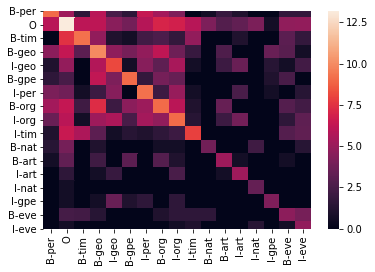

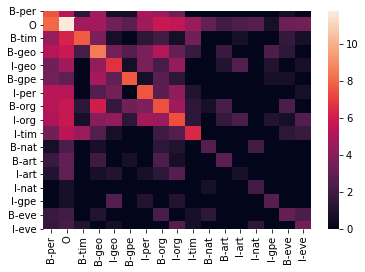

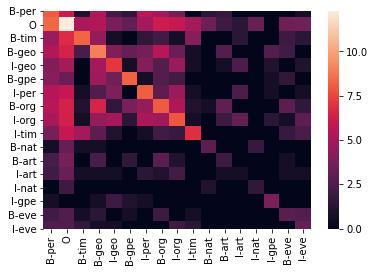

In [62]:
conf_train, conf_val, conf_test = show_confussion_images_HMM()

In [63]:
print("Confusion matrix train")
conf_train

Confusion matrix train


,B-per,O,B-tim,B-geo,I-geo,B-gpe,I-per,B-org,I-org,I-tim,B-nat,B-art,I-art,I-nat,I-gpe,B-eve,I-eve
B-per,8751.0,182.0,4.0,400.0,12.0,4.0,601.0,219.0,69.0,0.0,1.0,6.0,2.0,0.0,0.0,5.0,5.0
O,406.0,528113.0,439.0,465.0,93.0,48.0,353.0,1103.0,894.0,389.0,66.0,16.0,27.0,62.0,1.0,114.0,119.0
B-tim,0.0,1761.0,10163.0,123.0,2.0,1.0,9.0,13.0,5.0,125.0,0.0,0.0,2.0,0.0,0.0,22.0,5.0
B-geo,98.0,561.0,23.0,20802.0,110.0,53.0,123.0,502.0,39.0,6.0,0.0,14.0,0.0,0.0,33.0,19.0,1.0
I-geo,2.0,126.0,0.0,320.0,3556.0,1.0,91.0,24.0,236.0,1.0,0.0,7.0,34.0,0.0,3.0,1.0,9.0
B-gpe,4.0,11.0,0.0,525.0,67.0,8689.0,5.0,51.0,31.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,0.0
I-per,62.0,42.0,1.0,7.0,86.0,0.0,10102.0,7.0,142.0,1.0,0.0,0.0,12.0,0.0,1.0,0.0,3.0
B-org,203.0,568.0,8.0,1570.0,7.0,99.0,168.0,9017.0,412.0,2.0,0.0,32.0,0.0,0.0,0.0,17.0,9.0
I-org,35.0,423.0,1.0,180.0,278.0,11.0,217.0,113.0,8702.0,3.0,0.0,7.0,48.0,0.0,0.0,4.0,24.0
I-tim,2.0,675.0,273.0,23.0,1.0,3.0,2.0,4.0,7.0,2911.0,0.0,0.0,0.0,0.0,0.0,17.0,25.0


In [64]:
print("Confusion matrix validation")
conf_val

Confusion matrix validation


,B-per,O,B-tim,B-geo,I-geo,B-gpe,I-per,B-org,I-org,I-tim,B-nat,B-art,I-art,I-nat,I-gpe,B-eve,I-eve
B-per,1913.0,201.0,3.0,111.0,1.0,1.0,143.0,94.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
O,3047.0,129493.0,111.0,123.0,29.0,16.0,101.0,319.0,267.0,87.0,20.0,7.0,10.0,13.0,1.0,25.0,28.0
B-tim,82.0,512.0,2332.0,39.0,1.0,0.0,3.0,7.0,1.0,29.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0
B-geo,184.0,339.0,8.0,4959.0,31.0,13.0,39.0,172.0,21.0,5.0,0.0,5.0,0.0,0.0,10.0,3.0,0.0
I-geo,30.0,103.0,0.0,80.0,812.0,1.0,40.0,8.0,80.0,0.0,0.0,2.0,11.0,0.0,2.0,0.0,1.0
B-gpe,31.0,17.0,0.0,129.0,18.0,2180.0,1.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
I-per,207.0,180.0,0.0,11.0,33.0,0.0,2000.0,15.0,68.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
B-org,191.0,311.0,3.0,424.0,4.0,29.0,42.0,1832.0,101.0,3.0,1.0,8.0,0.0,0.0,0.0,9.0,0.0
I-org,155.0,323.0,1.0,54.0,73.0,3.0,115.0,87.0,1656.0,3.0,0.0,4.0,9.0,0.0,2.0,1.0,11.0
I-tim,30.0,222.0,93.0,11.0,1.0,0.0,0.0,6.0,12.0,616.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0


In [65]:
print("Confusion matrix test")
conf_test

Confusion matrix test


,B-per,O,B-tim,B-geo,I-geo,B-gpe,I-per,B-org,I-org,I-tim,B-nat,B-art,I-art,I-nat,I-gpe,B-eve,I-eve
B-per,3047.0,474.0,2.0,214.0,8.0,4.0,289.0,147.0,39.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0
O,4155.0,215511.0,178.0,223.0,42.0,22.0,141.0,495.0,408.0,159.0,30.0,6.0,3.0,24.0,0.0,30.0,34.0
B-tim,120.0,901.0,3885.0,95.0,1.0,0.0,4.0,7.0,1.0,64.0,0.0,0.0,3.0,0.0,0.0,6.0,3.0
B-geo,222.0,657.0,10.0,8136.0,54.0,23.0,39.0,268.0,27.0,1.0,0.0,13.0,0.0,0.0,13.0,7.0,0.0
I-geo,54.0,156.0,0.0,150.0,1269.0,1.0,59.0,13.0,114.0,1.0,0.0,1.0,11.0,0.0,2.0,0.0,2.0
B-gpe,63.0,27.0,0.0,132.0,35.0,3791.0,1.0,13.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0
I-per,236.0,366.0,1.0,12.0,48.0,0.0,3461.0,18.0,111.0,1.0,0.0,0.0,11.0,0.0,1.0,0.0,1.0
B-org,256.0,637.0,2.0,694.0,4.0,44.0,98.0,3096.0,197.0,2.0,1.0,20.0,0.0,0.0,0.0,17.0,4.0
I-org,180.0,599.0,1.0,97.0,142.0,3.0,179.0,130.0,2859.0,1.0,0.0,6.0,22.0,0.0,3.0,1.0,18.0
I-tim,40.0,387.0,152.0,18.0,2.0,0.0,1.0,7.0,5.0,959.0,0.0,0.0,0.0,0.0,0.0,5.0,10.0


### Number of sentences without any error

In [66]:
def sentences_no_errors_HMM(Y_true, Y_hat):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, sequence in enumerate(Y_true):
        pred = Y_hat[i]
        n = len(pred)
        count = 0
        for j, y_hat in enumerate(pred):
            if sequence[j] == y_hat:
                count +=1
        if count == n:
            num_correct+=1
            
    return num_correct

In [67]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_HMM(Y_train, Y_hat_train)
eval_val = sentences_no_errors_HMM(Y_val, Y_hat_val)
eval_test = sentences_no_errors_HMM(Y_test, Y_hat_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(Y_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 19532 Validation: 4152 Test: 6753


### Test sentences

In [68]:
test_sentences_raw = ['The programmers from Barcelona might write a sentence without a spell checker.',
                 'The programmers from Barchelona cannot write a sentence without a spell checker.',
                 'Jack London went to Parris.', 
                 'Jack London went to Paris.',
                 'We never though Microsoft would become such a big company.',
                 'We never though Microsof would become such a big company.',
                 'The president of U.S.A though they could win the war',
                 'The president of the United States of America though they could win the war',
                 'The king of Saudi Arabia wanted total control.',
                 'Robin does not want to go to Saudi Arabia.',
                 'Apple is a great company.',
                 'I really love apples and oranges.']

import nltk

test_sentences = [ nltk.word_tokenize(sent) for sent in test_sentences_raw]

In [69]:
for x in test_sentences:
    y = hmm.predict_labels(x)

    result = skseq.sequences.sequence.Sequence(x,y)
    print(result, '\n')

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

The/O programmers/O from/O Barchelona/O can/O not/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

Jack/B-per London/B-geo went/O to/O Parris/O ./O  

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O  

We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O  

We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company/O ./O  

The/O president/O of/O U.S.A/O though/O they/O could/O win/O the/O war/O  

The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O  

The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control/O ./O  

Robin/B-per does/B-per not/B-per want/B-per to/B-per go/B-per to/B-per Saudi/B-per Arabia/B-per ./B-per  

Apple/B-org is/O a/O great/O company/O ./O  

I/O really/O love/O apples/O and/O oranges/O ./O  



# Model 2: Structured perceptron

The first type of model we designed to solve the name entity task is a linear discriminative sequence model built using a structured perceptron. 

Discriminative sequence models aim to solve the following:

$$\underset{y\,\in\,\Lambda^N}{\textrm{arg max}}\ P(Y=y\,|\,X=x)=\underset{y\,\in\,\Lambda^N}{\textrm{arg max}}\ \boldsymbol{w}\cdot\boldsymbol{f}(x, y)$$

where $\boldsymbol{w}$ is the model's weight vector, and $\boldsymbol{f}(x, y)$ is a feature vector.

In order to select the best features  $\boldsymbol{f}(x, y)$, we performed model selection in the notebook `ComparisonFeatures.ipnb` in a validation set. Here we just train the model with all the features. To see the feature selection task see the notebook `ComparisonFeatures.ipnb`. The features that we considered were the following:

+ **Closest word**: This feature aims to solve the spelling mistake issue. Given a word `w`, it finds the closest word `w\_sim` belonging to an existing dictionary. If the `w` already belongs to the vocabulary, `w\_sim = w`. The feature has the form `closestWord:w\_sim::dist` where `dist`=distance(`w`, `w\_sim`). 

+ **Suffix**: Checks if the word has a suffix from this list: `['an', 'ian', 'ine', 'ite', 'er', 'eno', 'ish', 'ese', 'i', 'ic', 'iote']`. This feature aims to detect demonyms. The feature has the form `suffix:suffix_name::tag`.

+ **Capitalized**: Whether the word is capitalized or not. The feature has the form `capitalized:tag`.

+ **Uppercase**: Whether all the letters of the word are uppercase. The feature has the form `uppercase:tag`.

+ **Dot**: Whether the word contains dots. The feature is of the form `Dot:tag`.

+ **Hyphen**: Whether the word contains a hyphen. The feature is of the form `Hyphen:tag`.

+ **Numeric**: Whether the string is all numeric. The feature is of the form `Numeric:num\_digits::tag`, where `num\_digits` is the number of digits of the word.

+ **LettersNumbers**: Whether the word contains letters and numbers. The feature is of the form `LettersNumbers:tag`.

+ **DaysWeek**: Whether the word ends with -day. The feature is of the form `DaysWeek:tag`.



In [13]:
import skseq
from skseq.sequences import sequence
from skseq.sequences.sequence import Sequence
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary
import skseq.sequences.structured_perceptron as spc
from skseq.sequences import extended_feature
import time


In [14]:
def generate_sequence_list(X, y, word_to_pos, tag_to_pos):
    # Generate x and y dicts
    x_dict = LabelDictionary(word_to_pos.keys())
    y_dict = LabelDictionary(tag_to_pos.keys())
    # Generate SequenceList
    seq_list = SequenceList(x_dict, y_dict)
    # Add words/tags to sequencelist
    for i in range(len(X)):
        seq_list.add_sequence(X[i], y[i], x_dict, y_dict)
    return seq_list

In [15]:
train_seq = generate_sequence_list(X_train, Y_train, word_to_pos, tag_to_pos)

## Spelling mistakes

We create an Spelling_Correction object which uses the Edit distance to find the closest word inside a vocabulary. We use it as a feature for the spelling correction.

In [16]:
words = list(word_to_pos.keys())

len(words)

28012

In [17]:
#Create the spelling correction object (it will create the BK tree)
spelling = Spelling_Correction_c(words, tol = 1)

In [19]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling) #initialize
feature_mapper.build_features() #get the features

In [20]:
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'DaysWeek',
 'Dot',
 'Hyphen',
 'LettersNumbers',
 'Numeric',
 'capitalized',
 'closestWord',
 'final_prev_tag',
 'id',
 'init_tag',
 'prev_tag',
 'suffix',
 'uppercase'}

### Train perceptron

In [25]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)

In [26]:
%%time
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.927741
Epoch: 1 Accuracy: 0.943151
Epoch: 2 Accuracy: 0.947397
Epoch: 3 Accuracy: 0.950626
Epoch: 4 Accuracy: 0.952347
Epoch: 5 Accuracy: 0.954350
Epoch: 6 Accuracy: 0.955672
Epoch: 7 Accuracy: 0.956563
Epoch: 8 Accuracy: 0.957552
Epoch: 9 Accuracy: 0.958423
Epoch: 10 Accuracy: 0.959405
Epoch: 11 Accuracy: 0.959569
Epoch: 12 Accuracy: 0.960677
Epoch: 13 Accuracy: 0.960512
Epoch: 14 Accuracy: 0.961253
CPU times: user 1h 3min 2s, sys: 3.77 s, total: 1h 3min 6s
Wall time: 1h 3min 1s


### Make predictions

In [27]:
p = "Jack London went to Barchelona."
new_seq = skseq.sequences.sequence.Sequence(x=p.split(), y=[int(0) for w in p.split()])
new_seq


Jack/0 London/0 went/0 to/0 Barchelona./0 

In [28]:
sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True)

'Jack/B-per London/B-geo went/O to/O Barchelona./B-eve '

In [22]:
pred_val = []
for i in range(len(X_val)):
    p = X_val[i]
    new_seq = skseq.sequences.sequence.Sequence(x=p, y=[int(0) for w in p])
    res = sp.viterbi_decode(new_seq)[0]
    pred_val.append(res)

In [23]:
pred_test = []
for i in range(len(X_test)):
    p = X_test[i]
    new_seq = skseq.sequences.sequence.Sequence(x=p, y=[int(0) for w in p])
    res = sp.viterbi_decode(new_seq)[0]
    pred_test.append(res)

## Evaluate performance

### Accuracy

In [24]:
# Make predictions for the various sequences using the trained model.
pred_train = sp.viterbi_decode_corpus(train_seq)

In [25]:
def accuracy_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    correct = 0.0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                correct += 1
            total += 1
    return correct / total


def accuracy_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    correct = 0.0
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                correct += 1
            total += 1
    return correct / total

In [26]:
# Evaluate and print accuracies
eval_train = accuracy_corpus(train_seq.seq_list, pred_train)
eval_val = accuracy_predictions(Y_val, pred_val)
eval_test = accuracy_predictions(Y_test, pred_test)
print("SP -  Accuracy Train: %.3f Validation: %.3f Test: %.3f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.958 Validation: 0.949 Test: 0.950


### Confusion matrix

In [27]:
tags = list(tag_to_pos.keys())

def confusion_matrix_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    confusion = np.zeros((len(tags), len(tags)))
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                confusion[y_hat, y_hat] +=1
            else:
                confusion[sequence.y[j], y_hat] +=1
            
    return confusion


def confusion_matrix_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    confusion = np.zeros((len(tags), len(tags)))
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                confusion[y_hat, y_hat] +=1
            else:
                confusion[tag_to_pos[ys[j]], y_hat] +=1      
    return confusion

def show_confussion_images():
    eval_train = confusion_matrix_corpus(train_seq.seq_list, pred_train)
    eval_test = confusion_matrix_predictions(Y_test, pred_test)
    eval_val = confusion_matrix_predictions(Y_val, pred_val)

    eval_train = pd.DataFrame(eval_train, columns =tags, index = tags)
    eval_test = pd.DataFrame(eval_test, columns =tags, index = tags)
    eval_val = pd.DataFrame(eval_val, columns =tags, index = tags)
    
    sns.heatmap(np.log(eval_train+1))
    plt.show()
    
    sns.heatmap(np.log(eval_val+1))
    plt.show()
    
    sns.heatmap(np.log(eval_test+1))
    plt.show()
    
    return eval_train, eval_val, eval_test

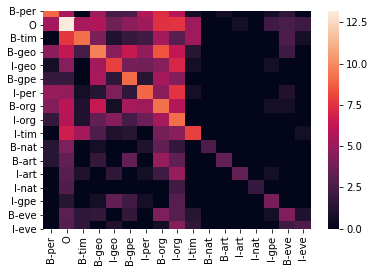

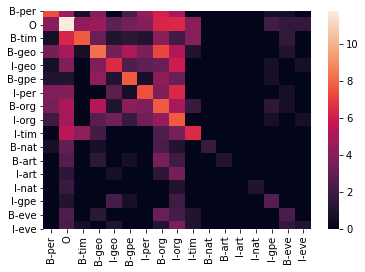

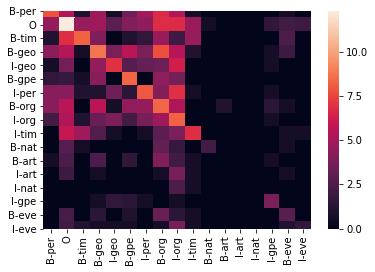

In [30]:
conf_train, conf_val, conf_test= show_confussion_images()

In [31]:
print("Confusion matrix train")
conf_train

Confusion matrix train


,B-per,O,B-tim,B-geo,I-geo,B-gpe,I-per,B-org,I-org,I-tim,B-nat,B-art,I-art,I-nat,I-gpe,B-eve,I-eve
B-per,7607.0,240.0,0.0,165.0,11.0,13.0,322.0,1521.0,375.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0
O,213.0,527743.0,227.0,302.0,39.0,102.0,180.0,1781.0,1909.0,184.0,0.0,0.0,1.0,0.0,8.0,12.0,7.0
B-tim,0.0,2121.0,9607.0,63.0,2.0,6.0,9.0,205.0,20.0,184.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
B-geo,106.0,536.0,10.0,15561.0,96.0,648.0,131.0,4733.0,553.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
I-geo,1.0,86.0,0.0,207.0,2729.0,51.0,42.0,85.0,1208.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
B-gpe,6.0,6.0,0.0,242.0,4.0,8839.0,3.0,217.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-per,145.0,127.0,1.0,3.0,65.0,4.0,8161.0,102.0,1855.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
B-org,82.0,431.0,2.0,604.0,1.0,224.0,186.0,10222.0,358.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
I-org,5.0,337.0,2.0,28.0,80.0,10.0,37.0,224.0,9323.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-tim,0.0,850.0,216.0,14.0,2.0,3.0,0.0,49.0,92.0,2716.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
print("Confusion matrix validation")
conf_val

Confusion matrix validation


,B-per,O,B-tim,B-geo,I-geo,B-gpe,I-per,B-org,I-org,I-tim,B-nat,B-art,I-art,I-nat,I-gpe,B-eve,I-eve
B-per,1635.0,112.0,1.0,49.0,0.0,9.0,84.0,472.0,131.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
O,63.0,132112.0,72.0,93.0,17.0,33.0,48.0,574.0,614.0,56.0,0.0,0.0,0.0,0.0,7.0,4.0,4.0
B-tim,1.0,568.0,2292.0,22.0,2.0,3.0,2.0,59.0,7.0,52.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
B-geo,31.0,134.0,1.0,3807.0,31.0,162.0,38.0,1405.0,176.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
I-geo,1.0,44.0,0.0,45.0,649.0,11.0,17.0,22.0,379.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
B-gpe,2.0,2.0,0.0,74.0,2.0,2230.0,1.0,61.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
I-per,46.0,49.0,0.0,0.0,16.0,1.0,1770.0,43.0,591.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B-org,37.0,144.0,0.0,184.0,2.0,62.0,43.0,2347.0,130.0,5.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
I-org,6.0,124.0,0.0,14.0,29.0,5.0,28.0,80.0,2209.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
I-tim,0.0,238.0,68.0,7.0,0.0,0.0,0.0,10.0,37.0,639.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print("Confusion matrix test")
conf_test

Confusion matrix test


,B-per,O,B-tim,B-geo,I-geo,B-gpe,I-per,B-org,I-org,I-tim,B-nat,B-art,I-art,I-nat,I-gpe,B-eve,I-eve
B-per,2616.0,237.0,2.0,121.0,1.0,32.0,147.0,849.0,226.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
O,98.0,219017.0,104.0,129.0,17.0,57.0,85.0,923.0,900.0,113.0,1.0,0.0,0.0,0.0,4.0,7.0,6.0
B-tim,2.0,1001.0,3803.0,51.0,0.0,2.0,4.0,110.0,6.0,100.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0
B-geo,76.0,246.0,1.0,6172.0,47.0,281.0,47.0,2354.0,237.0,2.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0
I-geo,1.0,38.0,0.0,93.0,1077.0,15.0,23.0,28.0,557.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
B-gpe,4.0,5.0,1.0,66.0,0.0,3881.0,0.0,82.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-per,65.0,67.0,2.0,2.0,32.0,3.0,3026.0,57.0,1011.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
B-org,67.0,264.0,0.0,280.0,1.0,90.0,95.0,4079.0,190.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0,0.0
I-org,8.0,209.0,2.0,27.0,47.0,8.0,42.0,129.0,3768.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
I-tim,0.0,396.0,126.0,12.0,1.0,0.0,1.0,18.0,45.0,985.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### Number of sentences without any error

In [34]:
def sentences_no_errors_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        n = len(pred.y)
        count = 0
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                count +=1
        if count == n:
            num_correct+=1
            
    return num_correct


def sentences_no_errors_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        n = len(pred.y)
        count = 0
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                count+=1
        if count==n:
            num_correct+=1
        
    return num_correct

In [35]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 16497 Validation: 3726 Test: 6131


### Save the model

In [38]:
sp.save_model("trained_models/perceptron_extended_features")

### Load existing model

In [21]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
sp.load_model(dir="trained_models/perceptron_extended_features")

### Test sentences

In [59]:
test_sentences_raw = ['The programmers from Barcelona might write a sentence without a spell checker.',
                 'The programmers from Barchelona cannot write a sentence without a spell checker.',
                 'Jack London went to Parris.', 
                 'Jack London went to Paris.',
                 'We never though Microsoft would become such a big company.',
                 'We never though Microsof would become such a big company.',
                 'The president of U.S.A though they could win the war',
                 'The president of the United States of America though they could win the war',
                 'The king of Saudi Arabia wanted total control.',
                 'Robin does not want to go to Saudi Arabia.',
                 'Apple is a great company.',
                 'I really love apples and oranges.']

In [60]:
import nltk

test_sentences = [ nltk.word_tokenize(sent) for sent in test_sentences_raw]

In [41]:
pred_test = []
for i in range(len(test_sentences)):
    p = test_sentences[i]
    new_seq = skseq.sequences.sequence.Sequence(x=p, y=[int(0) for w in p])
    res = sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True)
    pred_test.append(res)

In [42]:
for sent in pred_test:
    print(sent, '\n') 

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

The/O programmers/O from/O Barchelona/B-org can/O not/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

Jack/B-per London/B-geo went/O to/O Parris/B-org ./O  

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O  

We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O  

We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company/O ./O  

The/O president/O of/O U.S.A/B-org though/O they/O could/O win/O the/O war/O  

The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O  

The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control/O ./O  

Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia/I-geo ./O  

Apple/O is/O a/O great/O company/O ./O  

I/O really/O love/O apples/O and/O oranges/O ./O  



# Model 3: BiLSTM

In [73]:
import torchtext 
import torch

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Prepare data for LSTM

In [75]:
for i in range(len(X_train)):
    for word in X_train[i]:
        
        if word == '\x85':
            idx = X_train[i].index(word) 
            X_train[i].remove(word)
            Y_train[i].pop(idx)

        if word == '\x94':
            idx = X_train[i].index(word) 
            X_train[i].remove(word)
            Y_train[i].pop(idx) 
            
for i in range(len(X)):
    for word in X[i]:
        
        if word == '\x85':
            idx = X[i].index(word) 
            X[i].remove(word)
            Y[i].pop(idx)

        if word == '\x94':
            idx = X[i].index(word) 
            X[i].remove(word)
            Y[i].pop(idx) 

In [76]:
sequence = torchtext.data.Field()
full_sequence = torchtext.data.Field()
label = torchtext.data.Field(is_target=True)

fields = [('sequence', sequence), ('tag', label)] 
full_fields = [('sequence', full_sequence), ('tag', label)] 

In [77]:
class CustomDataSet(torchtext.data.Dataset):
    
    def __init__(self, X, y, fields, is_test = False, **kwargs):
        examples = []
        for i in range(len(X)):
            label = y[i] if not is_test else None
            text = X[i]
            examples.append(torchtext.data.Example.fromlist([text,label], fields))
        
        super().__init__(examples, fields, **kwargs)
    
    @staticmethod
    def sortkeys(ex):
        return len(ex.sequence)
    
    @classmethod
    def splits(cls, fields, X_train, y_train, X_val = None, y_val = None, X_test = None, y_test = None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        
        if X_train is not None:
            train_data = cls(X_train.copy(), y_train.copy(), fields, **kwargs)
        if X_val is not None:
            val_data = cls(X_val.copy(), y_val.copy(), fields, **kwargs)
        if X_test is not None:
            if y_test is not None:
                test_data = cls(X_test.copy(), y_test.copy(), fields, **kwargs)
            else:
                test_data = cls(X_test.copy(), None, fields, True, **kwargs)
                
        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [78]:
full_train_ds, full_test_ds = CustomDataSet.splits(full_fields, X, Y, X_val = None, y_val = None, X_test = X_test, y_test=Y_test)

In [79]:
train_ds, val_ds, test_ds = CustomDataSet.splits(fields, X_train, Y_train, X_val, Y_val, X_test, Y_test)

In [80]:
MAX_VOCAB_SIZE = 35000
sequence.build_vocab(train_ds, max_size = MAX_VOCAB_SIZE)
full_sequence.build_vocab(full_train_ds, max_size = MAX_VOCAB_SIZE)
label.build_vocab(train_ds)

In [81]:
print(len(label.vocab))
print(len(sequence.vocab))
print(len(full_sequence.vocab))

19
28011
30863


In [82]:
#the most common words of the vocabulary for test dataset 
full_sequence.vocab.freqs.most_common(10), sequence.vocab.freqs.most_common(10), label.vocab.freqs.most_common(10)

([('the', 39398),
  ('.', 35831),
  (',', 24773),
  ('in', 19780),
  ('of', 19735),
  ('to', 17462),
  ('a', 15411),
  ('and', 14992),
  ('The', 8529),
  ("'s", 8245)],
 [('the', 31414),
  ('.', 28666),
  (',', 19775),
  ('in', 15876),
  ('of', 15767),
  ('to', 13962),
  ('a', 12358),
  ('and', 11969),
  ('The', 6838),
  ("'s", 6571)],
 [('O', 532700),
  ('B-geo', 22384),
  ('B-tim', 12231),
  ('B-org', 12112),
  ('I-per', 10466),
  ('B-per', 10261),
  ('I-org', 10046),
  ('B-gpe', 9396),
  ('I-geo', 4411),
  ('I-tim', 3943)])

In [83]:
spelling = Spelling_Correction_c(list(sequence.vocab.stoi.keys()), tol = 1)

test_sentences_raw = ['The programmers from Barcelona might write a sentence without a spell checker.',
                 'The programmers from Barchelona cannot write a sentence without a spell checker.',
                 'Jack London went to Parris.', 
                 'Jack London went to Paris.',
                 'We never though Microsoft would become such a big company.',
                 'We never though Microsof would become such a big company.',
                 'The president of U.S.A though they could win the war',
                 'The president of the United States of America though they could win the war',
                 'The king of Saudi Arabia wanted total control.',
                 'Robin does not want to go to Saudi Arabia.',
                 'Apple is a great company.',
                 'I really love apples and oranges.']

test_sentences_raw = spelling.correct_text(test_sentences_raw)

import nltk

test_sentences = [ nltk.word_tokenize(sent) for sent in test_sentences_raw]

In [84]:
def save_torch_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_torch_model(model, path):
    model.load_state_dict(torch.load(path))
    model.to(device)

#### Train LSTM

In [85]:
def make_train_val_test_iterator(BATCH_SIZE=256):
    train_iterator = torchtext.data.BucketIterator(
        train_ds,
        batch_size = BATCH_SIZE,
        shuffle=True,
        device=device)

    val_iterator = torchtext.data.BucketIterator(
        val_ds,
        batch_size = 1,
        shuffle = False,
        device = device)

    test_iterator = torchtext.data.BucketIterator(
        test_ds,
        shuffle=False,
        batch_size = 1,
        device=device)
    
    return train_iterator, val_iterator, test_iterator

In [27]:
train_iterator, val_iterator, test_iterator = make_train_val_test_iterator(BATCH_SIZE=256)

In [86]:
#model
class RNN(torch.nn.Module):
    def __init__(self, vocab_dim, text, hidden_dim=256, output_dim=len(label.vocab), dropout=0.3, embedding_dim=256, bidirectional=True, num_layers=2):
        super().__init__()
        vocab = text.vocab
        self.embedding = torch.nn.Embedding(vocab_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)
        self.act = torch.nn.LeakyReLU(negative_slope=0.01)
        
    def forward(self, sequence):

        #question = [sent len, batch size]        
        embedded = self.embedding(sequence)
    
        #embedded = [sent len, batch size, emb dim]        
        output, hidden = self.rnn(embedded)   
        
        #output = [sent len, batch size, hid dim]  
        L, B, H = output.shape
        output = self.fc(output.view(-1, H)) #B*L, H
        output = output.view(L, B, -1) #L, B, output_dim
        output = self.act(output)

        return output

In [29]:
model = RNN(vocab_dim=len(sequence.vocab), text=sequence)
model.to(device)

RNN(
  (embedding): Embedding(28012, 256)
  (rnn): LSTM(256, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=19, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)

In [30]:
epochs = 8
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_epoch = []
validation_loss_epoch = []
train_accuracy_epoch = []
validation_accuracy_epoch = []

for epoch in range(1, epochs+1):
    train_loss, train_acc = [], []
    
    model.train()
    for batch in train_iterator:
        optimizer.zero_grad()
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model(seq) 
        L, B, C = output.shape
        loss = criterion(output.view(-1,C), tag.view(-1))
        loss.backward()
        optimizer.step()     
        train_loss.append(loss.item()) 
        
        # There is a problem bcs torchtext puts everything in the batch at the size of the max(len(item)) for item in batch.
        # Then accuracy is not faithful, because it also counts the <pad> tags which are easy to predict because they are always
        # with the tag 1 (the stoi from sequence also translates <pad> as 1)
        y_pred = torch.argmax(output, dim=2)
        mask = ~(tag == 1)
        n_real = mask.sum().item()
        masked_y_pred = y_pred[mask]
        masked_tag = tag[mask]
        acc = masked_y_pred == masked_tag
        acc = acc.sum().item() / n_real
        
        train_acc.append(acc)
        
    train_loss_epoch.append(np.mean(train_loss))
    train_accuracy_epoch.append(np.mean(train_acc))
        
    val_loss, val_acc = [], []
    model.eval()
    with torch.no_grad():
        for batch in val_iterator:
            seq, tag = batch.sequence.to(device), batch.tag.to(device)
            output = model(seq) 
            L, B, C = output.shape
            loss = criterion(output.view(-1,C), tag.view(-1))  
            val_loss.append(loss.item()) 
            y_pred = torch.argmax(output, dim=2) # we dont have the same problem here since we are doing batch size of 1
            acc = (y_pred == tag).sum().item() / (B*L)
            val_acc.append(acc)
    
    validation_loss_epoch.append(np.mean(val_loss))
    validation_accuracy_epoch.append(np.mean(val_acc))
            
    print('Epoch: %d ||| Train loss: %.4f ||| Validation loss: %.4f ||| Train acc: %.4f ||| Validation acc: %.4f |||' %
          (epoch, np.mean(train_loss), np.mean(val_loss), np.mean(train_acc), np.mean(val_acc)))

Epoch: 1 ||| Train loss: 0.3871 ||| Validation loss: 0.4334 ||| Train acc: 0.8246 ||| Validation acc: 0.8877 |||
Epoch: 2 ||| Train loss: 0.1196 ||| Validation loss: 0.2077 ||| Train acc: 0.9259 ||| Validation acc: 0.9447 |||
Epoch: 3 ||| Train loss: 0.0703 ||| Validation loss: 0.1594 ||| Train acc: 0.9545 ||| Validation acc: 0.9556 |||
Epoch: 4 ||| Train loss: 0.0534 ||| Validation loss: 0.1438 ||| Train acc: 0.9644 ||| Validation acc: 0.9594 |||
Epoch: 5 ||| Train loss: 0.0426 ||| Validation loss: 0.1324 ||| Train acc: 0.9711 ||| Validation acc: 0.9621 |||
Epoch: 6 ||| Train loss: 0.0345 ||| Validation loss: 0.1301 ||| Train acc: 0.9762 ||| Validation acc: 0.9627 |||
Epoch: 7 ||| Train loss: 0.0286 ||| Validation loss: 0.1384 ||| Train acc: 0.9805 ||| Validation acc: 0.9624 |||
Epoch: 8 ||| Train loss: 0.0230 ||| Validation loss: 0.1420 ||| Train acc: 0.9840 ||| Validation acc: 0.9624 |||


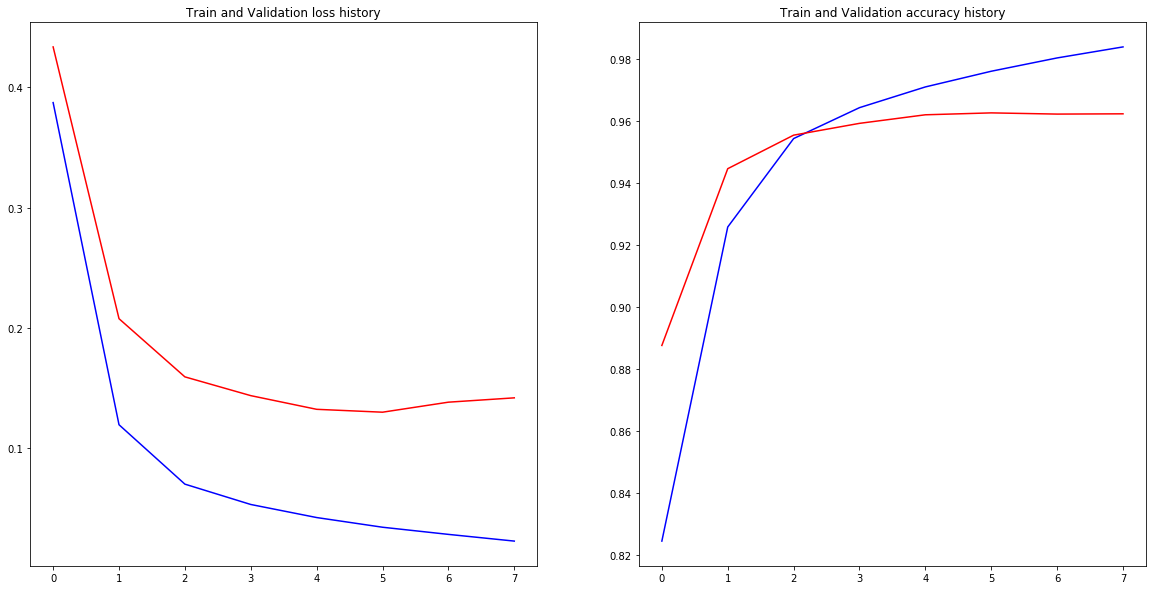

In [31]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,2,1)
ax.plot(train_loss_epoch, "b-")
ax.plot(validation_loss_epoch, "r-")
ax.set_title("Train and Validation loss history")
ax = plt.subplot(1,2,2)
ax.plot(train_accuracy_epoch, "b-")
ax.plot(validation_accuracy_epoch, "r-")
ax.set_title("Train and Validation accuracy history")
plt.show()

Train model with full data

In [32]:
def make_train_test_iterator(BATCH_SIZE=256, shuffle_train = True):
    train_iterator = torchtext.data.BucketIterator(
        full_train_ds,
        batch_size = BATCH_SIZE,
        shuffle=shuffle_train,
        device=device)

    test_iterator = torchtext.data.BucketIterator(
        full_test_ds,
        shuffle=False,
        batch_size = 1,
        device=device)
    
    return train_iterator, test_iterator

In [87]:
train_iterator, test_iterator = make_train_test_iterator(BATCH_SIZE=256)

In [88]:
model = RNN(vocab_dim=len(full_sequence.vocab), text=full_sequence)
model.to(device)

RNN(
  (embedding): Embedding(30863, 256)
  (rnn): LSTM(256, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=19, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)

In [89]:
epochs = 8
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs+1):
    print('%d/%d' % (epoch, epochs))
    model.train()
    for batch in train_iterator:
        optimizer.zero_grad()
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model(seq)
        L, B, C = output.shape
        loss = criterion(output.view(-1,C), tag.view(-1))
        loss.backward()
        optimizer.step()

1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8


In [90]:
save_torch_model(model, 'trained_models/LSTM_params_001.txt')

In [38]:
train_iterator, test_iterator = make_train_test_iterator(BATCH_SIZE=256, shuffle_train = False) #make iterator again to reset position

In [39]:
y_pred_train = []
real_tags_train = []
y_pred_test = []
real_tags_test = []

with torch.no_grad():
    for batch in train_iterator:
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model(seq)
        y_pred = torch.argmax(output, dim=2)
        
        y_pred_train.append(y_pred.T.tolist())
        real_tags_train.append(tag.T.tolist())
        
    for batch in test_iterator:
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model(seq) 
        y_pred = torch.argmax(output, dim=2)
        
        y_pred_test.append(y_pred.T.tolist())
        real_tags_test.append(tag.T.tolist())

In [40]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [41]:
y_pred_train = flatten_list(y_pred_train)
y_pred_test = flatten_list(y_pred_test)
real_tags_train = flatten_list(real_tags_train)
real_tags_test = flatten_list(real_tags_test)

In [42]:
def compute_acc(real_tags, pred_tags):
    compare = [np.array([pred_tags[j][i] == tagseq[i] for i in range(len(tagseq))]) for j,tagseq in enumerate(real_tags)]
    all_correct = np.sum([np.all(x) for x in compare])/len(compare)
    acc = np.sum([np.sum(x) for x in compare])/np.sum([x.shape[0] for x in compare])
    
    return acc, all_correct

In [43]:
accuracy_train, n_correct_train = compute_acc(real_tags_train, y_pred_train)
accuracy_test, n_correct_test = compute_acc(real_tags_test, y_pred_test)

In [44]:
print('\t\t|\t Train \t\t|\t Test \t\t|')
print('Accuracy \t|\t %.4f \t|\t %.4f \t|' % (accuracy_train, accuracy_test) )
print('All Correct \t|\t %.4f \t|\t %.4f \t|' % (n_correct_train, n_correct_test) )

		|	 Train 		|	 Test 		|
Accuracy 	|	 0.9993 	|	 0.9608 	|
All Correct 	|	 0.9684 	|	 0.5848 	|


In [45]:
def confusion_matrix(real_tags, pred_tags):
    u_tags = list(label.vocab.stoi.keys())
    u_tags_idx = list(range(len(u_tags)))
    
    cm = np.zeros((len(u_tags), len(u_tags)))
    
    for y, y_pred in zip(real_tags, pred_tags):
        n = len(y)
        for i in range(n):
            cm[y[i], y_pred[i]] += 1
            
    return cm

In [46]:
cm_tr = confusion_matrix(real_tags_train, y_pred_train)
cm_ts = confusion_matrix(real_tags_test, y_pred_test)

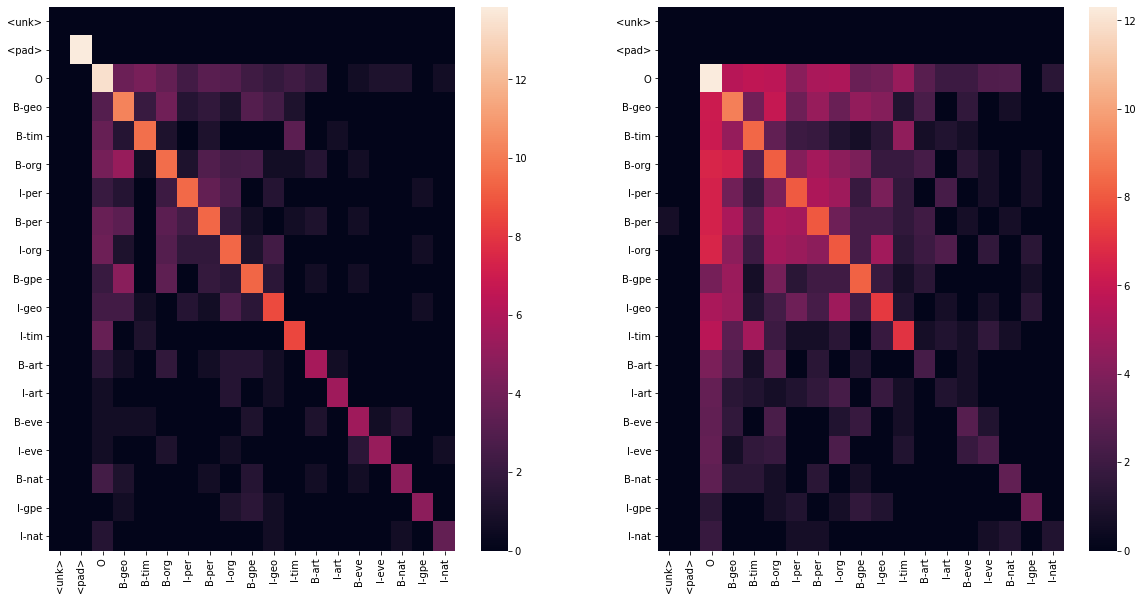

In [47]:
plt.figure(figsize=(20,10))
ax = plt.subplot(121)
sns.heatmap(np.log(cm_tr+1))
ax.set_xticklabels(list(label.vocab.stoi.keys()), rotation='vertical')
ax.set_yticklabels(list(label.vocab.stoi.keys()), rotation='horizontal')
ax = plt.subplot(122)
sns.heatmap(np.log(cm_ts+1))
ax.set_xticklabels(list(label.vocab.stoi.keys()), rotation='vertical')
ax.set_yticklabels(list(label.vocab.stoi.keys()), rotation='horizontal')
plt.show()

In [48]:
def predict_sentence(sent, sequence=sequence, label=label, model=model, device=device, true_label=None):
    numerized = [full_sequence.vocab.stoi[x] for x in sent]
    tensor = torch.tensor([numerized], device=device).T
    pred = model(tensor)
    pred_seq = torch.argmax(pred, dim=2).T.tolist()[0]
    pred_lbl = [label.vocab.itos[x] for x in pred_seq]
    
    if true_label is None:
        return(' '.join([x[0] + '/' + x[1] for x in zip(sent, pred_lbl)]))
    else:
        return(' '.join([x[0] + '/' + x[1] + '/' + x[2] for x in zip(sent, pred_lbl, true_label)]))

In [49]:
with torch.no_grad():
    for s in test_sentences:
        print(predict_sentence(s), '\n')

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 

The/O programmers/O from/O Barchelona/O can/O not/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 

Jack/B-per London/B-geo went/O to/O Parris/O ./O 

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O 

We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 

We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company/O ./O 

The/O president/O of/O U.S.A/O though/O they/O could/O win/O the/O war/O 

The/O president/O of/O the/O United/B-geo States/I-org of/I-org America/I-org though/O they/O could/O win/O the/O war/O 

The/O king/O of/O Saudi/B-org Arabia/I-org wanted/O total/O control/O ./O 

Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia/I-geo ./O 

Apple/B-org is/O a/O great/O company/O ./O 

I/O really/O love/O apples/O and/O oranges/O ./O 



# Model 3.5 BiLSTM with CRF Layer

In [91]:
#!pip install pytorch-crf
from torchcrf import CRF

In [54]:
train_iterator, val_iterator, test_iterator = make_train_val_test_iterator(BATCH_SIZE=256)

In [92]:
#model
class RNN_CRF(torch.nn.Module):
    def __init__(self, vocab_dim, text, hidden_dim=256, output_dim=len(label.vocab), dropout=0.5, embedding_dim=256, bidirectional=True, num_layers=2):
        super().__init__()
        self.vocab = text.vocab
        self.embedding = torch.nn.Embedding(vocab_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)
        self.act = torch.nn.LeakyReLU(negative_slope=0.01)
        self.crf = CRF(output_dim)
        
    def forward(self, sequence):

        #question = [sent len, batch size]        
        embedded = self.embedding(sequence)
    
        #embedded = [sent len, batch size, emb dim]        
        output, hidden = self.rnn(embedded)   
        
        #output = [sent len, batch size, hid dim]  
        L, B, H = output.shape
        output = self.fc(output.view(-1, H)) #B*L, H
        output = output.view(L, B, -1) #L, B, output_dim
        output = self.act(output)
        
        #output = torch.tensor(self.crf.decode(output))
        
        return output

In [56]:
model_crf = RNN_CRF(vocab_dim=len(sequence.vocab), text=sequence)
model_crf.to(device)

RNN_CRF(
  (embedding): Embedding(28012, 256)
  (rnn): LSTM(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=19, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (crf): CRF(num_tags=19)
)

In [57]:
epochs = 8
criterion = model_crf.crf
optimizer = torch.optim.Adam(model_crf.parameters(), lr=1e-3)

train_loss_epoch = []
validation_loss_epoch = []
train_accuracy_epoch = []
validation_accuracy_epoch = []

for epoch in range(1, epochs+1):
    train_loss, train_acc = [], []
    
    model_crf.train()
    for batch in train_iterator:
        optimizer.zero_grad()
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model_crf(seq) 
        L, B, C = output.shape
        loss = -criterion(output, tag)
        loss.backward()
        optimizer.step()     
        train_loss.append(loss.item())
        y_pred = torch.tensor(model_crf.crf.decode(output)).T.to(device)
        acc = (y_pred == tag).sum().item() / (B*L)
        train_acc.append(acc)
        
    train_loss_epoch.append(np.mean(train_loss))
    train_accuracy_epoch.append(np.mean(train_acc))
        
    val_loss, val_acc = [], []
    model_crf.eval()
    with torch.no_grad():
        for batch in val_iterator:
            seq, tag = batch.sequence.to(device), batch.tag.to(device)
            output = model_crf(seq) 
            L, B, C = output.shape
            loss = -criterion(output, tag)  
            val_loss.append(loss.item()) 
            y_pred = torch.tensor(model_crf.crf.decode(output)).T.to(device)
            acc = (torch.argmax(output, dim=2) == tag).sum().item() / (B*L)
            val_acc.append(acc)
    
    validation_loss_epoch.append(np.mean(val_loss))
    validation_accuracy_epoch.append(np.mean(val_acc))
            
    print('Epoch: %d ||| Train loss: %.4f ||| Validation loss: %.4f ||| Train acc: %.4f ||| Validation acc: %.4f |||' %
          (epoch, np.mean(train_loss), np.mean(val_loss), np.mean(train_acc), np.mean(val_acc)))

Epoch: 1 ||| Train loss: 5065.5459 ||| Validation loss: 10.2543 ||| Train acc: 0.9146 ||| Validation acc: 0.8870 |||
Epoch: 2 ||| Train loss: 1631.6558 ||| Validation loss: 4.5111 ||| Train acc: 0.9654 ||| Validation acc: 0.9417 |||
Epoch: 3 ||| Train loss: 892.0403 ||| Validation loss: 3.4914 ||| Train acc: 0.9798 ||| Validation acc: 0.9520 |||
Epoch: 4 ||| Train loss: 669.5644 ||| Validation loss: 3.1310 ||| Train acc: 0.9842 ||| Validation acc: 0.9557 |||
Epoch: 5 ||| Train loss: 539.2692 ||| Validation loss: 2.9643 ||| Train acc: 0.9871 ||| Validation acc: 0.9575 |||
Epoch: 6 ||| Train loss: 447.8291 ||| Validation loss: 3.0267 ||| Train acc: 0.9892 ||| Validation acc: 0.9568 |||
Epoch: 7 ||| Train loss: 373.5718 ||| Validation loss: 3.0136 ||| Train acc: 0.9908 ||| Validation acc: 0.9576 |||
Epoch: 8 ||| Train loss: 312.3883 ||| Validation loss: 3.1182 ||| Train acc: 0.9923 ||| Validation acc: 0.9570 |||


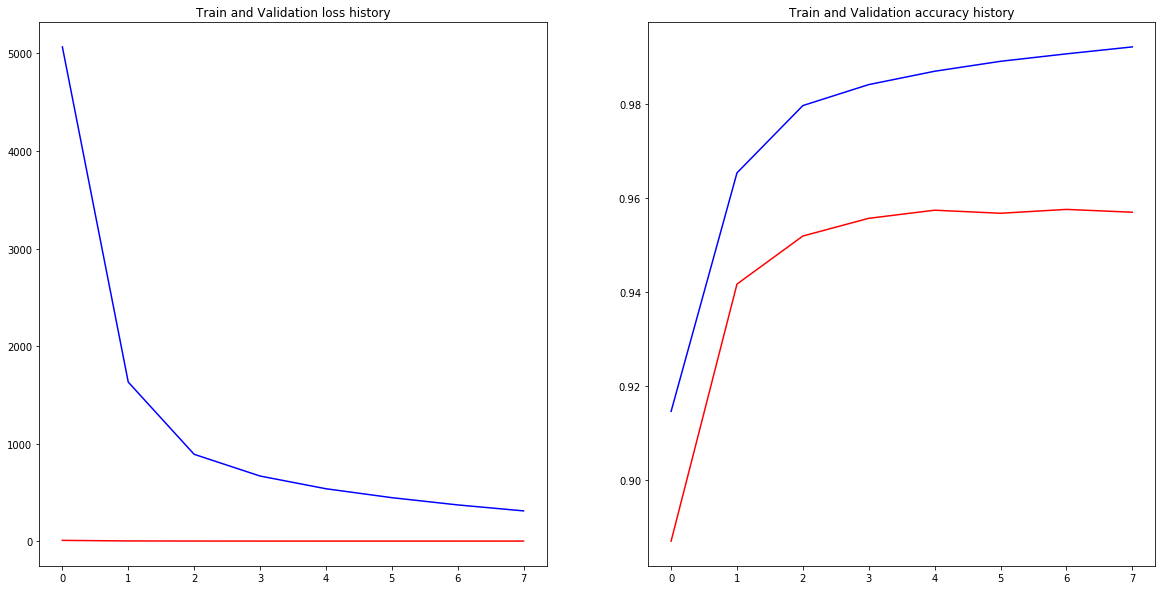

In [58]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,2,1)
ax.plot(train_loss_epoch, "b-")
ax.plot(validation_loss_epoch, "r-")
ax.set_title("Train and Validation loss history")
ax = plt.subplot(1,2,2)
ax.plot(train_accuracy_epoch, "b-")
ax.plot(validation_accuracy_epoch, "r-")
ax.set_title("Train and Validation accuracy history")
plt.show()

In [59]:
train_iterator, test_iterator = make_train_test_iterator(BATCH_SIZE=256)

In [93]:
model_crf = RNN_CRF(vocab_dim=len(full_sequence.vocab), text=full_sequence)
model_crf.to(device)

RNN_CRF(
  (embedding): Embedding(30863, 256)
  (rnn): LSTM(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=19, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (crf): CRF(num_tags=19)
)

In [94]:
epochs = 8
criterion = model_crf.crf
optimizer = torch.optim.Adam(model_crf.parameters(), lr=1e-3)

for epoch in range(1, epochs+1):
    print('%d/%d' % (epoch, epochs))
    model_crf.train()
    for batch in train_iterator:
        optimizer.zero_grad()
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model_crf(seq) 
        L, B, C = output.shape
        loss = -criterion(output, tag)
        loss.backward()
        optimizer.step()     

1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8


In [95]:
save_torch_model(model_crf, 'trained_models/LSTM_CRF_params_001.txt')

In [63]:
train_iterator, test_iterator = make_train_test_iterator(BATCH_SIZE=256, shuffle_train = False)

In [64]:
y_pred_train = []
real_tags_train = []
y_pred_test = []
real_tags_test = []

with torch.no_grad():
    for batch in train_iterator:
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model_crf(seq)
        y_pred = torch.tensor(model_crf.crf.decode(output)).T.to(device)
        
        y_pred_train.append(y_pred.T.tolist())
        real_tags_train.append(tag.T.tolist())
        
    for batch in test_iterator:
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model_crf(seq) 
        y_pred = torch.tensor(model_crf.crf.decode(output)).T.to(device)
        
        y_pred_test.append(y_pred.T.tolist())
        real_tags_test.append(tag.T.tolist())

In [65]:
y_pred_train = flatten_list(y_pred_train)
y_pred_test = flatten_list(y_pred_test)
real_tags_train = flatten_list(real_tags_train)
real_tags_test = flatten_list(real_tags_test)

In [66]:
accuracy_train, n_correct_train = compute_acc(real_tags_train, y_pred_train)
accuracy_test, n_correct_test = compute_acc(real_tags_test, y_pred_test)

In [67]:
print('\t\t|\t Train \t\t|\t Test \t\t|')
print('Accuracy \t|\t %.4f \t|\t %.4f \t|' % (accuracy_train, accuracy_test) )
print('All Correct \t|\t %.4f \t|\t %.4f \t|' % (n_correct_train, n_correct_test) )

		|	 Train 		|	 Test 		|
Accuracy 	|	 0.9942 	|	 0.9634 	|
All Correct 	|	 0.8130 	|	 0.6123 	|


In [68]:
cm_tr = confusion_matrix(real_tags_train, y_pred_train)
cm_ts = confusion_matrix(real_tags_test, y_pred_test)

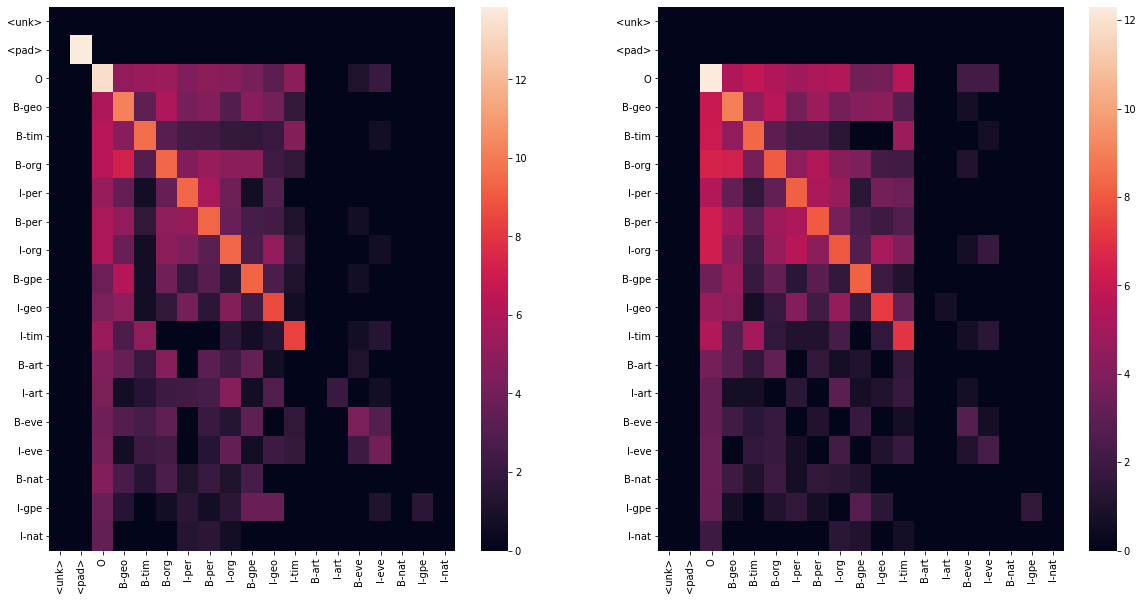

In [69]:
plt.figure(figsize=(20,10))
ax = plt.subplot(121)
sns.heatmap(np.log(cm_tr+1))
ax.set_xticklabels(list(label.vocab.stoi.keys()), rotation='vertical')
ax.set_yticklabels(list(label.vocab.stoi.keys()), rotation='horizontal')
ax = plt.subplot(122)
sns.heatmap(np.log(cm_ts+1))
ax.set_xticklabels(list(label.vocab.stoi.keys()), rotation='vertical')
ax.set_yticklabels(list(label.vocab.stoi.keys()), rotation='horizontal')
plt.show()

In [70]:
def predict_sentence(sent, sequence=sequence, label=label, model=model, device=device, true_label=None):
    numerized = [full_sequence.vocab.stoi[x] for x in sent]
    tensor = torch.tensor([numerized], device=device).T
    pred = model_crf(tensor)
    pred_seq = model_crf.crf.decode(pred)[0]
    pred_lbl = [label.vocab.itos[x] for x in pred_seq]
    
    if true_label==None:
        return(' '.join([x[0] + '/' + x[1] for x in zip(sent, pred_lbl)]))
    else:
        return(' '.join([x[0] + '/' + x[1] + '/' + x[2] for x in zip(sent, pred_lbl, true_label)]))

In [71]:
with torch.no_grad():
    for s in test_sentences:
        print(predict_sentence(s), '\n')

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/B-tim checker/I-tim ./O 

The/O programmers/O from/O Barchelona/O can/O not/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 

Jack/B-per London/B-geo went/O to/O Parris/O ./O 

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O 

We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 

We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company/O ./O 

The/O president/O of/O U.S.A/B-gpe though/O they/O could/O win/O the/O war/O 

The/O president/O of/O the/O United/B-geo States/I-geo of/O America/B-geo though/O they/O could/O win/O the/O war/O 

The/O king/O of/O Saudi/B-org Arabia/I-org wanted/O total/O control/O ./O 

Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia/I-geo ./O 

Apple/B-org is/O a/O great/O company/O ./O 

I/O really/O love/O apples/O and/O oranges/O ./O 



In [72]:
import json
json.dumps(full_sequence.vocab.itos)

'["<unk>", "<pad>", "the", ".", ",", "in", "of", "to", "a", "and", "The", "\'s", "for", "has", "is", "on", "that", "with", "have", "said", "was", "says", "from", "by", "at", "say", "as", "U.S.", "an", "are", "\\"", "will", "were", "his", "Mr.", "it", "government", "been", "killed", "he", "people", "not", "its", "after", "officials", "two", "be", "President", "A", "also", "more", "United", "country", "military", "who", "they", "than", "but", "their", "In", "last", "Iraq", "which", "He", "had", "one", "about", "least", "this", "year", "new", "other", "Tuesday", "States", "Thursday", "police", "week", "forces", "Monday", "Wednesday", "Friday", "Minister", "against", "since", "over", "group", "Iran", "$", "troops", "Sunday", "-", "Saturday", "would", "into", "when", "three", "security", "Iraqi", "during", "first", "out", "up", "month", "nuclear", "Afghanistan", "attacks", "China", "between", "oil", "militants", "Palestinian", "years", "attack", "city", "Bush", "or", "Israel", "Israeli", "t

# Model 3.5.5 BiLSTM with BERT as Embedding

In [ ]:
#!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

In [ ]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens')
#corpus_embeddings = embedder.encode(corpus)

In [ ]:
train_iterator, val_iterator, test_iterator = make_train_val_test_iterator(BATCH_SIZE=256)

In [ ]:
#model
class RNN_BERT(torch.nn.Module):
    def __init__(self, vocab, embedder=embedder, hidden_dim=256, output_dim=len(label.vocab), dropout=0.5, num_layers=2):
        super().__init__()

        self.vocab = vocab
        self.embedder = embedder
        self.rnn = torch.nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=True)
        self.fc = torch.nn.Linear(hidden_dim*2, output_dim)
        self.act = torch.nn.LeakyReLU(negative_slope=0.01)
        
    def forward(self, sequence):
        
        seq = sequence.cpu()
        emb = torch.tensor([self.embedder.encode([self.vocab.itos[w] for w in seq[:,i]]) for i in range(seq.shape[1])])
        emb = emb.permute(1,0,2)
        emb = emb.to(device)
    
        #embedded = [sent len, batch size, emb dim]        
        output, hidden = self.rnn(emb)   
        
        #output = [sent len, batch size, hid dim]  
        L, B, H = output.shape
        output = self.fc(output.view(-1, H)) #B*L, H
        output = output.view(L, B, -1) #L, B, output_dim
        #output = self.act(output)
        
        return output

In [ ]:
model_bert = RNN_BERT(vocab=sequence.vocab)
model_bert.to(device)

In [ ]:
epochs = 8
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bert.parameters(), lr=1e-3)

train_loss_epoch = []
validation_loss_epoch = []
train_accuracy_epoch = []
validation_accuracy_epoch = []

for epoch in range(1, epochs+1):
    train_loss, train_acc = [], []
    
    model_bert.train()
    for batch in train_iterator:
        optimizer.zero_grad()
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model_bert(seq) 
        #print(output.shape, tag.shape)
        L, B, C = output.shape
        #print(output.view(-1,C).shape, tag.view(-1).shape)
        loss = criterion(output.view(-1,C), tag.view(-1))
        loss.backward()
        optimizer.step()     
        train_loss.append(loss.item()) 
        acc = (torch.argmax(output, dim=2) == tag).sum().item() / (B*L)
        #print((torch.argmax(output, dim=1) == tag).sum())
        #print((tag.shape[0]*tag.shape[1]))
        train_acc.append(acc)
        
    train_loss_epoch.append(np.mean(train_loss))
    train_accuracy_epoch.append(np.mean(train_acc))
        
    val_loss, val_acc = [], []
    model_bert.eval()
    with torch.no_grad():
        for batch in val_iterator:
            seq, tag = batch.sequence.to(device), batch.tag.to(device)
            output = model_bert(seq) 
            L, B, C = output.shape
            loss = criterion(output.view(-1,C), tag.view(-1))  
            val_loss.append(loss.item()) 
            acc = (torch.argmax(output, dim=2) == tag).sum().item() / (B*L)
            val_acc.append(acc)
    
    validation_loss_epoch.append(np.mean(val_loss))
    validation_accuracy_epoch.append(np.mean(val_acc))
            
    print('Epoch: %d ||| Train loss: %.4f ||| Validation loss: %.4f ||| Train acc: %.4f ||| Validation acc: %.4f |||' %
          (epoch, np.mean(train_loss), np.mean(val_loss), np.mean(train_acc), np.mean(val_acc)))

In [ ]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,2,1)
ax.plot(train_loss_epoch, "b-")
ax.plot(validation_loss_epoch, "r-")
ax.set_title("Train and Validation loss history")
ax = plt.subplot(1,2,2)
ax.plot(train_accuracy_epoch, "b-")
ax.plot(validation_accuracy_epoch, "r-")
ax.set_title("Train and Validation accuracy history")
plt.show()